In [1]:
# dependencies
from IPython.display import Image
from matplotlib import pyplot as plt

import cv2 as cv
import argparse
import sys
import numpy as np
import os.path

In [2]:
input_path = 'Pa140025.jpg'
is_video = False

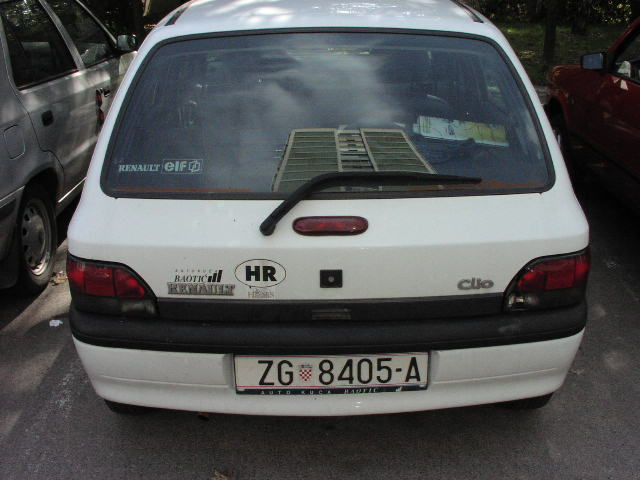

In [3]:
Image(input_path) 

## Inpute Receiever

In [4]:
# winName = 'Deep learning object detection in OpenCV'
# cv.namedWindow(winName, cv.WINDOW_NORMAL)

In [5]:
# Process inputs

# Open the input file
cap = cv.VideoCapture(input_path)

if is_video:
    outputFile = input_path + '_yolo_out_py.avi'
else:
    outputFile = input_path + '_yolo_out_py.jpg'

## YOLO Plate Detection

### Initialize the parameters

In [6]:
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4  #Non-maximum suppression threshold

inpWidth = 416  #608     #Width of network's input image
inpHeight = 416 #608     #Height of network's input image

In [7]:
# Load names of classes
classesFile = "../conf/classes.names";

In [8]:
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

### Restore the nural network

In [9]:
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "../conf/darknet-yolov3.cfg";
modelWeights = "../conf/lapi.weights";

In [10]:
net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

### Define the post processing functions

In [11]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [12]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom, frame):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv.FILLED)
    #cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

In [13]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        print("out.shape : ", out.shape)
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            if detection[4]>confThreshold:
                print(detection[4], " - ", scores[classId], " - th : ", confThreshold)
                print(detection)
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        
        # calculate bottom and right
        bottom = top + height
        right = left + width
        
        #crop the plate out
        cropped = frame[top:bottom, left:right].copy()
        # drawPred
        drawPred(classIds[i], confidences[i], left, top, right, bottom, frame)
        
    return cropped
        

### Detection

out.shape :  (507, 6)
out.shape :  (2028, 6)
0.8818527  -  0.0  - th :  0.5
[0.5150221  0.7686662  0.3335506  0.08097434 0.8818527  0.        ]
0.9989587  -  0.99862516  - th :  0.5
[0.5173495  0.7722337  0.30081242 0.08711532 0.9989587  0.99862516]
out.shape :  (8112, 6)
Done processing !!!
Output file is stored as  Pa140025.jpg_yolo_out_py.jpg


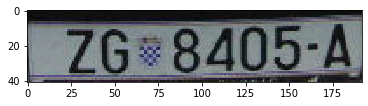

In [14]:
# Get the video writer initialized to save the output video
if is_video:
    vid_writer = cv.VideoWriter(outputFile, cv.VideoWriter_fourcc('M','J','P','G'), 30, (round(cap.get(cv.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))

while cv.waitKey(1) < 0:

    # get frame from the video
    hasFrame, frame = cap.read() #frame: an image object from cv2

    # Stop the program if reached end of video
    if not hasFrame:
        print("Done processing !!!")
        print("Output file is stored as ", outputFile)
        cv.waitKey(3000)
        break

    # Create a 4D blob from a frame.
    blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    cropped = postprocess(frame, outs)

    # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
    #cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    # Write the frame with the detection boxes
    if is_video:
        vid_writer.write(frame.astype(np.uint8))
    else:
        plt.imshow(cropped)
        cv.imwrite('cropped_plate_final.jpg', cropped.astype(np.uint8))    
    # save 
        cv.imwrite(outputFile, frame.astype(np.uint8))

## Validation

M Turk

## Plate Segmentation

In [15]:
def get_contour_precedence(contour, cols):
    tolerance_factor = 10
    origin = cv.boundingRect(contour)
    return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]

In [16]:
def square(img):
    """
    This function resize non square image to square one (height == width)
    :param img: input image as numpy array
    :return: numpy array
    """

    # image after making height equal to width
    squared_image = img

    # Get image height and width
    h = img.shape[0]
    w = img.shape[1]

    # In case height superior than width
    if h > w:
        diff = h-w
        if diff % 2 == 0:
            x1 = np.zeros(shape=(h, diff//2))
            x2 = x1
        else:
            x1 = np.zeros(shape=(h, diff//2))
            x2 = np.zeros(shape=(h, (diff//2)+1))

        squared_image = np.concatenate((x1, img, x2), axis=1)

    # In case height inferior than width
    if h < w:
        diff = w-h
        if diff % 2 == 0:
            x1 = np.zeros(shape=(diff//2, w))
            x2 = x1
        else:
            x1 = np.zeros(shape=(diff//2, w))
            x2 = np.zeros(shape=((diff//2)+1, w))

        squared_image = np.concatenate((x1, img, x2), axis=0)

    return squared_image

In [17]:
def sort(vector):
    sort = True
    while (sort == True):

        sort = False
        for i in range(len(vector) - 1):
            x_1 = vector[i][0]
            y_1 = vector[i][1]

            for j in range(i + 1, len(vector)):

                x_2 = vector[j][0]
                y_2 = vector[j][1]

                if (x_1 >= x_2 and y_2 >= y_1):
                    tmp = vector[i]
                    vector[i] = vector[j]
                    vector[j] = tmp
                    sort = True

                elif (x_1 < x_2 and y_2 > y_1):
                    tmp = vector[i]
                    vector[i] = vector[j]
                    vector[j] = tmp
                    sort = True
    return vector

In [146]:
def plate_segmentation(img_file_path):

    img = cv.imread(img_file_path)
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    height = img.shape[0]
    width = img.shape[1]
    area = height * width

    scale1 = 0.001
    scale2 = 0.1
    area_condition1 = area * scale1
    area_condition2 = area * scale2
    # global thresholding
    ret1,th1 = cv.threshold(imgray,127,255,cv.THRESH_BINARY)

    # Otsu's thresholding
    ret2,th2 = cv.threshold(imgray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    # Otsu's thresholding after Gaussian filtering
    blur = cv.GaussianBlur(imgray,(5,5),0)
    ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    contours, hierarchy = cv.findContours(th3, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # sort contours
    contours = sorted(contours, key=cv.contourArea, reverse=True)

    cropped = dict()
    #cropped = []
    for cnt in contours:
        (x,y,w,h) = cv.boundingRect(cnt)
        distance_center = (2*x+w)/2
        
        if distance_center in cropped:
            pass
        else:            
            if (w * h > area_condition1 and w * h < area_condition2 and w/h > 0.6 and h/w > 0.6):
                cv.drawContours(img, [cnt], 0, (0, 255, 0), 1)
                cv.rectangle(img, (x,y), (x+w,y+h), (255, 0, 0), 1)
                c = th2[y:y+h,x:x+w]
                c = np.array(c)
                c = cv.bitwise_not(c)
                c = square(c)
                c = cv.resize(c,(28,28), interpolation = cv.INTER_AREA)
                cropped[distance_center] = c
                #cropped.append(c)
    
    sorted_cropped = []
    for x_center in sorted(cropped):
        sorted_cropped.append(cropped[x_center])

    cv.imwrite('detection.png', img)
    return img, sorted_cropped

In [147]:
img, digits = plate_segmentation('cropped_plate_final.jpg')

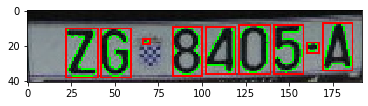

In [148]:
plt.imshow(img)

In [149]:
len(digits)

9

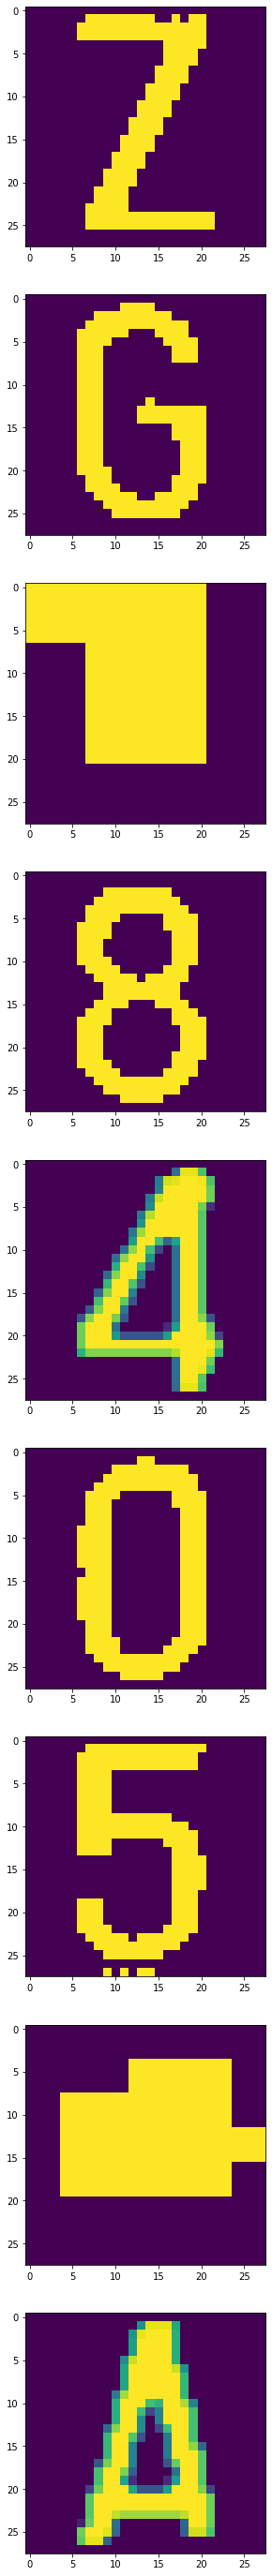

In [150]:
fig, axs = plt.subplots(len(digits))
fig.set_size_inches(20,50)
for ax in range(len(axs)):
    axs[ax].imshow(digits[ax])


## Char-Num Recoginition

In [110]:
import pandas as pd
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [111]:
# Load model
model = load_model('../conf/cnn_classifier.h5')

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [ ]:
# # Detect chars
# digits = plate_segmentation('demo/plates/PENNSYLVANIA.jpg')

In [ ]:
# Predict
#for d in digits:
for d in sorted_digits:

    d = np.reshape(d, (1,28,28,1))
    out = model.predict(d)
    # Get max pre arg
    p = []
    precision = 0
    for i in range(len(out)):
        z = np.zeros(36)
        z[np.argmax(out[i])] = 1.
        precision = max(out[i])
        p.append(z)
    prediction = np.array(p)

    # one hot encoding
    alphabets = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    classes = []
    for a in alphabets:
        classes.append([a])
    ohe = OneHotEncoder(handle_unknown='ignore', categorical_features=None)
    ohe.fit(classes)
    pred = ohe.inverse_transform(prediction)

#     if precision > 0.8:
#         print('Prediction : ' + str(pred[0][0]) + ' , Precision : ' + str(precision))
        
    print('Prediction : ' + str(pred[0][0]) + ' , Precision : ' + str(precision))

# CNN Rcognizer Training

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from matplotlib import pyplot as plt

In [ ]:
# Load dataset

In [ ]:
# Create dictionary for alphabets and related numbers
alphabets_dic = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J',
             10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T',
             20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: '0', 27: '1', 28: '2', 29:'3',
             30: '4', 31: '5', 32: '6', 33: '7', 34: '8', 35: '9'}

In [ ]:
alphabets = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

In [ ]:
dataset_classes = []
for cls in alphabets:
    dataset_classes.append([cls])

In [ ]:
# Load old dataset
d = open("data.pickle","rb")
l = open("labels.pickle","rb")
data = pickle.load(d)
labels = pickle.load(l)

In [ ]:
label_list = []
for l in labels:
    label_list.append([l])

In [ ]:
# One hot encoding format for output
ohe = OneHotEncoder(handle_unknown='ignore', categorical_features=None)
ohe.fit(dataset_classes)
labels_ohe = ohe.transform(label_list).toarray()

In [ ]:
data = np.array(data)
labels = np.array(labels)

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, labels_ohe, test_size=0.20, random_state=42)

In [ ]:
X_train = X_train.reshape(29260,28,28,1)
X_test = X_test.reshape(7316,28,28,1)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
# CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(36, activation='softmax'))

In [ ]:
print(model.summary())

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=20, batch_size=64)

In [ ]:
model.save('cnn_classifier.h5')

In [ ]:
# Visualization
plt.figure(figsize=[8, 6])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure(figsize=[8, 6])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()